# Common Voice language identification with lidbox

This example shows how to train and evaluate a TensorFlow model for language identification using the `lidbox` application programming interface (API), instead of the command line interface (CLI).

It is assumed requirements have been installed and preparation steps 1 and 2 have been completed.
See `lidbox/examples/common-voice/README.md`.

In [1]:
# For easier debugging and code modification
%load_ext autoreload
%autoreload 2

## Experiment configuration

Let's begin by creating a configuration dictionary for end-to-end (e2e) training and evaluation of our 4-language Common Voice dataset.
There are several steps to specify, but in return, they define the full e2e pipeline.

In [2]:
config = {}

### Datasets

First, we define the metadata of all datasets we want to include.
In our case, it is only one dataset, containing 4 labels.
Let's call it `common-voice-4`.

In [3]:
config["datasets"] = [
    {
        "key": "common-voice-4",
        # If an utterance does not have one of these labels, the utterance will be ignored
        "labels": ["br", "et", "mn", "tr"],
        "splits": [
            # Define metadata directories for training and test splits
            # These have been created by scripts/prepare.bash
            {"key": "train", "path": "./data/train"},
            {"key": "test", "path": "./data/test"},
        ],
    },
]

### Pre-processing
Before feature extraction, we shuffle the metadata and create 2 second signal chunks with 0.5 second overlap.
Then, each dataset split will be cached to disk as binary files.
We also apply a simple (naive even) energy-based voice activity detection (VAD) approach to remove silence segments longer than 0.1 seconds.

In [4]:
config["pre_initialize"] = {"shuffle_utterances": True}
config["pre_process"] = {
    # Remove silence with VAD 
    "rms_vad": {
        # VAD threshold, the proportion of 10 ms window RMS to mean RMS over all 10 ms windows,
        # higher values will drop more data
        "strength": 0.1,
        "vad_frame_length_ms": 10,
        "min_non_speech_length_ms": 100,
    },
    # If a signal is shorter than 2 seconds, append it to itself until it is at least 2 seconds
    "repeat_too_short_signals": {"min_length_ms": 2000},
    # Create 2 second utterances with 0.5 second overlap
    "chunks": {"length_ms": 2000, "step_ms": 1500},
    # Serialize all 2 second chunks to directory `./lidbox-cache`
    "cache": {
        "directory": "./lidbox-cache",
        "batch_size": 1000,
        "key": "signals_2sec",
        "log_interval": 5000,
        # We want the cache to be created before training
        "consume": True,
    },
}

### Feature extraction
From these 2 second chunks, we extract mean-normalized log-scale Mel-spectra with 40 Mel-bins.
These tensors will have shape `(198, 40)`.
We write feature extraction input and output into TensorBoard for later inspection.
We cache extracted features during the first epoch of training to avoid re-extracting features.

In [5]:
config["features"] = {
    # Extract in batches
    "batch_size": 100,
    "type": "logmelspectrogram",
    # Default window normalization length is -1, i.e. whole utterance
    "window_normalization": {"normalize_variance": False},
}
config["post_process"] = {
    # Take 50 first batches and 16 first samples of each batch and write TensorBoard summaries
    "tensorboard": {"num_batches": 50, "batch_size": 16},
    # Cache with "consume: false" gets filled during the first epoch of training (or if the dataset iterator is exhausted some other way)
    "cache": {
        "directory": "./lidbox-cache/features",
        "batch_size": 1000,
        "key": "logmelspectrogram",
        "consume": False,
    }
}

### Training and evaluation configuration
Finally, we define the training pipeline.
We choose the [x-vector](https://danielpovey.com/files/2018_icassp_xvectors.pdf) model, use Adam for optimization, and stop early when validation loss has not improved within 5 epochs.

You can also use your own Keras training pipeline.
This is discussed at the end of the notebook.

In [6]:
config["experiment"] = {
    "cache_directory": "./lidbox-cache",
    # Arbitrary key to distinguish different experiments of the same model,
    # does not have to match datasets key
    "name": "common-voice-4",
    # Choose a model module from lidbox/models
    "model": {"key": "xvector"},
    "optimizer": {"cls": "Adam"},
    "callbacks": [
        {"cls": "TensorBoard"},
        {"cls": "ModelCheckpoint", "kwargs": {"monitor": "val_loss", "mode": "min"}},
        {"cls": "EarlyStopping", "kwargs": {
            "patience": 5,
            "mode": "min",
            "monitor": "val_loss",
        }},
    ],
    "metrics": [{"cls": "SparseCategoricalAccuracy"}],
    "loss": {
        "cls": "SparseCategoricalCrossentropy",
        "kwargs": {"from_logits": True},
    },
    "input_shape": [198, 40],
    "output_shape": [4],
    "keras_fit_kwargs": {"epochs": 20},
    # Specify splits
    "data": {
        "train": {"split": "train", "batch_size": 64, "shuffle_buffer_size": 10000},
        "validation": {"split": "test", "batch_size": 64},
        "test": {"split": "test", "batch_size": 64, "evaluate_metrics": [
            {"name": "sparse_average_detection_cost"},
            {"name": "sklearn_classification_report"},
            {"name": "confusion_matrix"},
        ]},
    },
}

We now have a full pipeline configured:

In [7]:
config

{'datasets': [{'key': 'common-voice-4',
   'labels': ['br', 'et', 'mn', 'tr'],
   'splits': [{'key': 'train', 'path': './data/train'},
    {'key': 'test', 'path': './data/test'}]}],
 'pre_initialize': {'shuffle_utterances': True},
 'pre_process': {'rms_vad': {'strength': 0.1,
   'vad_frame_length_ms': 10,
   'min_non_speech_length_ms': 100},
  'repeat_too_short_signals': {'min_length_ms': 2000},
  'chunks': {'length_ms': 2000, 'step_ms': 1500},
  'cache': {'directory': './lidbox-cache',
   'batch_size': 1000,
   'key': 'signals_2sec',
   'log_interval': 5000,
   'consume': True}},
 'features': {'batch_size': 100,
  'type': 'logmelspectrogram',
  'window_normalization': {'normalize_variance': False}},
 'post_process': {'tensorboard': {'num_batches': 50, 'batch_size': 16},
  'cache': {'directory': './lidbox-cache/features',
   'batch_size': 1000,
   'key': 'logmelspectrogram',
   'consume': False}},
 'experiment': {'cache_directory': './lidbox-cache',
  'name': 'common-voice-4',
  'model

### Configuration validation

The amount of complexity in the `lidbox` configuration `dict` might be a bit overwhelming.
For this reason, simple JSON schema validation is included in `lidbox`.
This might help you detect invalid configurations before running the pipeline.

In [8]:
from lidbox.schemas import validate_config_dict_and_get_error_string as validate_config

error_str = validate_config(config)
if error_str:
    print(error_str)
else:
    print("config ok")

config ok


## Creating the dataset iterators

All training data in `lidbox` is moved around using `tf.data.Dataset` iterators.
In theory, this allows datasets of unbounded size.
In practice, you probably need a lot of other tools in addition to `lidbox` if you work with massive datasets (several 10,000 hours of speech).

In any case, let us start by loading the metadata files from disk.

### Loading the metadata

In [9]:
import lidbox.api

# Flatten the list of dataset metadata
split2meta, labels = lidbox.api.get_flat_dataset_config(config)
# Read content of all metadata files
split2meta = lidbox.api.load_all_metadata_from_paths(split2meta)
# Merge metadata over all datasets
split2meta = lidbox.api.merge_dataset_metadata(split2meta)

2020-05-19 19:43:07.634 I lidbox.api: Scanning dataset 'common-voice-4' split 'train' for valid metadata files
2020-05-19 19:43:07.634 I lidbox.api: Found 3 valid metadata files:
  ./data/train/utt2path
  ./data/train/utt2dur
  ./data/train/utt2label
2020-05-19 19:43:07.635 I lidbox.api: Key 'datafiles' not given for split 'train', assuming all valid metadata files should be used
2020-05-19 19:43:07.635 I lidbox.api: Using 3 metadata files:
  ./data/train/utt2path
  ./data/train/utt2dur
  ./data/train/utt2label
2020-05-19 19:43:07.635 I lidbox.api: Scanning dataset 'common-voice-4' split 'test' for valid metadata files
2020-05-19 19:43:07.636 I lidbox.api: Found 3 valid metadata files:
  ./data/test/utt2path
  ./data/test/utt2dur
  ./data/test/utt2label
2020-05-19 19:43:07.636 I lidbox.api: Key 'datafiles' not given for split 'test', assuming all valid metadata files should be used
2020-05-19 19:43:07.636 I lidbox.api: Using 3 metadata files:
  ./data/test/utt2path
  ./data/test/utt2du

### Create the iterators

Now, create the full e2e pipeline.
Note that this would not normally load any audio files from disk, but because we specified  `pre_process.cache.consume` to `True`, the signal chunks will be cached eagerly, before training.
Features will not be extracted yet, the pipeline is only configured for feature extraction.

In [10]:
split2ds = lidbox.api.create_datasets(split2meta, labels, config)

2020-05-19 19:43:07.702 I lidbox.api: Creating dataset iterator for split 'train' with metadata containing 5 keys
2020-05-19 19:43:07.702 I lidbox.api: 'pre_initialize' defined in config, updating metadata before creating dataset iterator.
2020-05-19 19:43:07.705 I lidbox.dataset.steps: 'allow_unknown_labels' is False, dropping all utterances which are not in the set of all labels.
2020-05-19 19:43:07.706 I lidbox.dataset.steps: All utterances have valid labels.
2020-05-19 19:43:07.707 I lidbox.dataset.steps: 'shuffle_utterances' is True, shuffling utterance id list.
2020-05-19 19:43:07.711 I lidbox.dataset.steps: Utterance id list was modified, updating all metadata to ensure correct order.
2020-05-19 19:43:07.718 I lidbox.dataset.steps: Initializing and preparing tf.data.Dataset instance from 14 steps:
  initialize
  load_audio
  drop_empty
  compute_rms_vad
  apply_vad
  drop_empty
  repeat_too_short_signals
  create_signal_chunks
  cache
  consume
  extract_features
  consume_to_te

2020-05-19 19:43:27.556 I lidbox.dataset.steps: Applying step number 7: 'repeat_too_short_signals'.
2020-05-19 19:43:27.556 I lidbox.dataset.steps: Repeating all signals until they are at least 2000 ms
2020-05-19 19:43:27.563 I lidbox.dataset.steps: Applying step number 8: 'create_signal_chunks'.
2020-05-19 19:43:27.563 I lidbox.dataset.steps: Dividing every signal in the dataset into new signals by creating signal chunks of length 2000 ms and offset 1500 ms. Maximum amount of padding allowed in the last chunk is 0 ms.
2020-05-19 19:43:27.614 I lidbox.dataset.steps: Applying step number 9: 'cache'.
2020-05-19 19:43:27.614 I lidbox.dataset.steps: Caching dataset in batches of size 1000 to directory './lidbox-cache/dataset/test' with key 'signals_2sec'.
2020-05-19 19:43:27.619 I lidbox.dataset.steps: Applying step number 10: 'consume'.
2020-05-19 19:43:27.620 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = 5000
2020-05-19 19:43:29.34

Take some time reading the log output.
It shows all dataset steps that `lidbox` applies on the `tf.data.Dataset` iterators for all dataset splits, based on the config dictionary we defined.

After running the above step, you should have a large file under `./lidbox-cache/dataset/train`.
This allows TensorFlow to read all 2 second utterances sequentially.
Try running the previous command again and it should use the cache instead of reading all wav-files from disk.

### Visualize features and listen to audio

It might be useful to look at the extracted features and listen to the 2 second utterances to make sure the pipeline is working.
`lidbox` writes some TensorBoard summaries that allows you to do this.
Start up a TensorBoard instance and inspect the features (tabs `images` and `audio`).

**NOTE** This might leave the `tensorboard` process running and you must kill it manually (run e.g. `ps u | grep tensorboard` to find the pid).
For this reason, I prefer to avoid the tensorboard extension and instead use a separate terminal to run `tensorboard --logdir ./lidbox-cache/xvector/common-voice-4/tensorboard`.
The below cell has been included for demonstration purposes.

In [11]:
%load_ext tensorboard
%tensorboard --logdir ./lidbox-cache/xvector/common-voice-4/tensorboard

Reusing TensorBoard on port 6006 (pid 17332), started 3:09:47 ago. (Use '!kill 17332' to kill it.)

## Training

Now we are ready to fit the x-vector model to the training data.

In [12]:
keras_history = lidbox.api.run_training(split2ds, config)

2020-05-19 19:43:31.852 I lidbox.dataset.steps: Converting all elements to tuple pairs (inputs, targets) and dropping all other values.
2020-05-19 19:43:31.877 I lidbox.dataset.steps: Converting all elements to tuple pairs (inputs, targets) and dropping all other values.
2020-05-19 19:43:31.881 I lidbox.api: User script has not defined a 'train' function, will use default approach
2020-05-19 19:43:32.274 I lidbox.api: Model initialized:
Model: "x-vector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 198, 40)]         0         
_________________________________________________________________
frame1 (FrameLayer)          (None, 198, 512)          103704    
_________________________________________________________________
frame2 (FrameLayer)          (None, 99, 512)           787340    
_________________________________________________________________
frame3 (Frame

## Evaluation

After early stopping, the best checkpoint has been written to `lidbox-cache/xvector/common-voice-4/checkpoints`.
Now, we can predict log-softmax language scores for all test utterances and compute some metrics.

2020-05-19 19:44:46.892 I lidbox.dataset.steps: Converting all elements to tuple pairs (inputs, targets) and dropping all other values.
2020-05-19 19:44:46.897 I lidbox.api: User script has not defined a 'predict' function, will use default approach
2020-05-19 19:44:47.157 I lidbox.api: Model initialized:
Model: "x-vector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 198, 40)]         0         
_________________________________________________________________
frame1 (FrameLayer)          (None, 198, 512)          103704    
_________________________________________________________________
frame2 (FrameLayer)          (None, 99, 512)           787340    
_________________________________________________________________
frame3 (FrameLayer)          (None, 33, 512)           787076    
_________________________________________________________________
frame4 (FrameLa

(<Figure size 400x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb21594c8e0>)

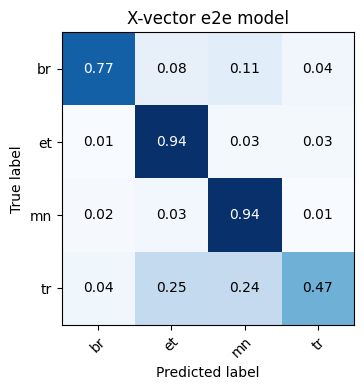

In [13]:
from lidbox.visualization import draw_confusion_matrix

metrics = lidbox.api.evaluate_test_set(split2ds, split2meta, labels, config)
confusion_matrix = next(m["result"] for m in metrics if m["name"] == "confusion_matrix")
draw_confusion_matrix(confusion_matrix, labels, title="X-vector e2e model")

# Custom Keras model with lidbox features

If you prefer to use your own Keras training setup, you can still use `lidbox` as a feature extractor.
After all, `lidbox` training is only a thin wrapper over Keras.

`split2ds` contains a dictionary of `tf.data.Dataset` iterators by training-test split.
`lidbox` uses `dict` objects for dataset iterator elements.
For example, the 5 first samples of the training set:

id: common_voice_et_18308539-000001, label: et, target: 1, input: (198, 40)
id: common_voice_mn_18580548-000002, label: mn, target: 2, input: (198, 40)
id: common_voice_tr_17344866-000001, label: tr, target: 3, input: (198, 40)
id: common_voice_tr_19421427-000001, label: tr, target: 3, input: (198, 40)
id: common_voice_mn_18580720-000001, label: mn, target: 2, input: (198, 40)


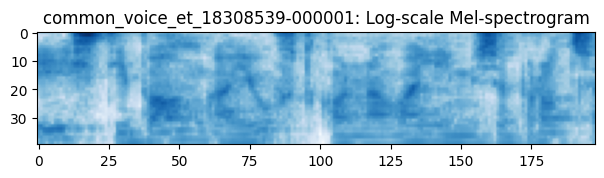

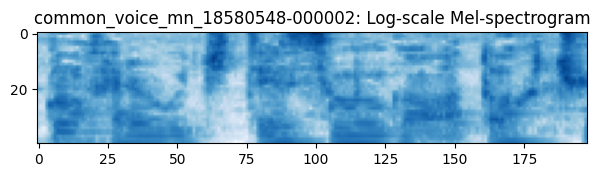

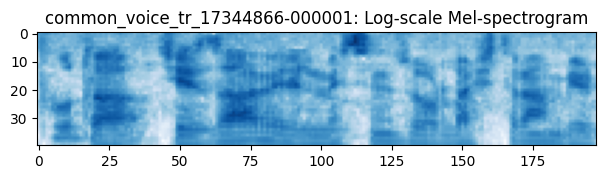

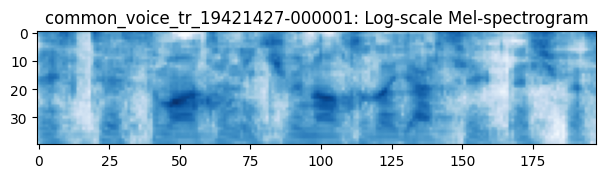

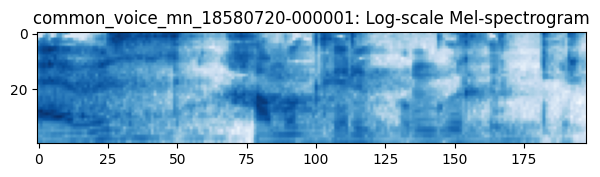

In [14]:
from lidbox.visualization import draw_spectrogram

for x in split2ds["train"].take(5).as_numpy_iterator():
    # TensorFlow uses `bytes` objects for all strings so we must explicitly decode them
    uttid = x["id"].decode("utf-8")
    label = x["label"].decode("utf-8")
    target = x["target"]
    melspec = x["input"]
    print("id: {}, label: {}, target: {}, input: {}".format(uttid, label, target, melspec.shape))
    draw_spectrogram(melspec, "{}: Log-scale Mel-spectrogram".format(uttid))

`tf.keras.Model.fit` expects `tf.data.Dataset` iterators that return tuples of `(inputs, targets)`.
This is simple to achieve with the `tf.data.Dataset` iterator:

In [15]:
training_set = split2ds["train"].map(lambda x: (x["input"], x["target"]))
test_set = split2ds["test"].map(lambda x: (x["input"], x["target"]))

In [16]:
training_set, test_set

(<MapDataset shapes: ((None, 40), ()), types: (tf.float32, tf.int32)>,
 <MapDataset shapes: ((None, 40), ()), types: (tf.float32, tf.int32)>)

Then define your model and fit it to the dataset.
Here, we use channel dropout to increase robustness and LSTMs for learning language classes from the time steps.

In [17]:
from tensorflow.keras.layers import (
    Input,
    SpatialDropout1D,
    LSTM,
    BatchNormalization,
    GlobalAveragePooling1D,
    Dense,
)
from tensorflow.keras import Model

def make_my_model(input_shape, num_outputs):
    input = Input(shape=input_shape, name="inputs")
    x = SpatialDropout1D(0.5, name="channel_dropout")(input)
    x = LSTM(200, return_sequences=True, name="lstm_1")(x)
    x = BatchNormalization(axis=1, name="batchnorm_lstm1")(x)
    x = LSTM(200, return_sequences=True, name="lstm_2")(x)
    x = BatchNormalization(axis=1, name="batchnorm_lstm2")(x)
    x = GlobalAveragePooling1D(name="avg_pool_time")(x)
    x = BatchNormalization(axis=1, name="batchnorm_pooling")(x)
    x = Dense(500, activation="relu", name="fc_relu")(x)
    output = Dense(num_outputs, activation="softmax", name="outputs")(x)
    return Model(inputs=[input], outputs=[output], name="my_model")

my_model = make_my_model([198, 40], 4)
my_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")
my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 198, 40)]         0         
_________________________________________________________________
channel_dropout (SpatialDrop (None, 198, 40)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 198, 200)          192800    
_________________________________________________________________
batchnorm_lstm1 (BatchNormal (None, 198, 200)          792       
_________________________________________________________________
lstm_2 (LSTM)                (None, 198, 200)          320800    
_________________________________________________________________
batchnorm_lstm2 (BatchNormal (None, 198, 200)          792       
_________________________________________________________________
avg_pool_time (GlobalAverage (None, 200)               0  

In [ ]:
my_model.fit(
    training_set.shuffle(10000).batch(32),
    validation_data=test_set.batch(32),
    epochs=6)

Epoch 1/6
696/696 [==============================] - 17s 25ms/step - loss: 1.0252 - val_loss: 1.1684
Epoch 2/6
696/696 [==============================] - 17s 24ms/step - loss: 0.7587 - val_loss: 0.7790
Epoch 3/6
696/696 [==============================] - 17s 25ms/step - loss: 0.6393 - val_loss: 0.6428
Epoch 4/6
696/696 [==============================] - 17s 25ms/step - loss: 0.5599 - val_loss: 0.5756
Epoch 5/6
696/696 [==============================] - 17s 25ms/step - loss: 0.5126 - val_loss: 0.6953
Epoch 6/6
459/696 [==================>...........] - ETA: 5s - loss: 0.4580

There are also some simple evaluation helpers you can use.

In [ ]:
# Predict test set
predictions = my_model.predict(test_set.batch(32))

# Combine each test utterance id with its prediction
# NOTE this step assumes you do not shuffle the test_set dataset iterator
utt2prediction = sorted(lidbox.api.zip_utt2vector(split2ds["test"], predictions), key=lambda t: t[0])
for uttid, prediction in utt2prediction[:5]:
    print(uttid, prediction)

# Recall that in our pre-processing step, we created 2 second chunks from all input
# A common way of merging chunk predictions is averaging
utt2prediction = lidbox.api.group_chunk_predictions_by_parent_id(utt2prediction)
for uttid, prediction in utt2prediction[:5]:
    print(uttid, prediction)

# Collect correct labels
utt2target = dict(lidbox.api.collect_targets(labels, split2meta["test"]))
for uttid, _ in utt2prediction[:5]:
    print(uttid, utt2target[uttid])
    
# Evaluate confusion matrix and scikit-learn classification report
metric_config = [{"name": "confusion_matrix"}, {"name": "sklearn_classification_report"}]
metrics = list(lidbox.api.evaluate_metrics_for_predictions(utt2prediction, utt2target, metric_config, labels))
print(metrics)
confusion_matrix = next(m["result"] for m in metrics if m["name"] == "confusion_matrix")
draw_confusion_matrix(confusion_matrix, labels, title="Custom e2e model")

# PLDA+Naive Bayes on language embeddings
`lidbox` contains a simple pipeline for training back-end classifiers on language embeddings, extracted from a hidden layer of a trained model.
The example below can be done automatically with `lidbox`, but this demonstration shows how you can customize the back-end classification.

## Extract language embeddings from a trained Keras model
Lets convert `my_model` to an embedding extractor, using `fc_relu` as the embedding layer.

In [ ]:
import tensorflow as tf


embedding_layer = my_model.get_layer(name="fc_relu")
embedding_layer.activation = None
embedding_extractor = tf.keras.Model(inputs=my_model.inputs, outputs=[embedding_layer.output])
embedding_extractor.trainable = False

# Convert the Keras model into a TensorFlow concrete function, i.e. graph, to allow its usage in a dataset iterator
extractor_input_spec = tf.TensorSpec(
    embedding_extractor.inputs[0].shape,
    embedding_extractor.inputs[0].dtype)
extractor_fn = tf.function(
    lambda inputs: embedding_extractor(inputs, training=False),
    input_signature=[extractor_input_spec]).get_concrete_function()

We now have an embedding extraction function that takes Mel-spectra as input and returns the outputs of `fc_relu` in the trained `my_model`.
Lets map the function over all training and test samples to create language embedding vectors.

In [ ]:
# Place embedding extraction ops on the GPU for all model input in the training and test set
def append_embeddings(x):
    with tf.device("/GPU:0"):
        return dict(x, embedding=extractor_fn(x["input"]))
split2embeddings = {
    "train": split2ds["train"].batch(100).map(append_embeddings),
    "test": split2ds["test"].batch(100).map(append_embeddings),
}

# Now extract embeddings and convert them to numpy arrays, which we can use in scikit-learn
split2numpy_ds, target2label = lidbox.api.extract_embeddings_as_numpy_data(
    split2embeddings,
    labels)

We now have numpy data that we can feed to some scikit-learn model.

In [ ]:
train_data = split2numpy_ds["train"]
for uttid, x, y in zip(train_data["ids"][:5], train_data["X"][:5], train_data["y"][:5]):
    print("uttid: {}, embedding shape: {}, label: {}, target: {}".format(
        uttid, x.shape, target2label[y], y))

## Preprocess language vectors

In [ ]:
import lidbox.embeddings.sklearn_utils
import sklearn.preprocessing
import sklearn.discriminant_analysis
import sklearn.decomposition
import matplotlib.pyplot as plt


train, test = split2numpy_ds["train"], split2numpy_ds["test"]

# Standardize features on training set
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(train["X"])
train["X"] = scaler.transform(train["X"])
test["X"] = scaler.transform(test["X"])

# Reduce dimensions with PLDA, fitted on training set
plda = lidbox.embeddings.sklearn_utils.fit_plda(train, test)
train["X"] = plda.transform(train["X"])
test["X"] = plda.transform(test["X"])

# L2 normalize all vectors to lay on a hyper sphere
train["X"] = sklearn.preprocessing.normalize(train["X"])
test["X"] = sklearn.preprocessing.normalize(test["X"])

# Draw random sample of 100 reduced embedding vectors
label2sample = lidbox.embeddings.sklearn_utils.draw_random_sample(train, test, labels, target2label)
# Plot embeddings and PCA projection
pca = {"2D": sklearn.decomposition.PCA(n_components=2).fit(train["X"])}
lidbox.embeddings.sklearn_utils.plot_embedding_demo(test, target2label, label2sample["test"], pca)

## Fit Gaussian Naive Bayes

In [ ]:
import sklearn.naive_bayes
import numpy as np

clf = sklearn.naive_bayes.GaussianNB().fit(train["X"], train["y"])

# Predict test set
predictions = clf.predict_log_proba(test["X"]) 
# Filter -inf values
predictions = np.maximum(predictions, -100)

# Combine utterance ids with predictions and correct labels
utt2prediction = zip(test["ids"], predictions)
utt2prediction = lidbox.api.group_chunk_predictions_by_parent_id(utt2prediction)
utt2target = dict(lidbox.api.collect_targets(labels, split2meta["test"]))
    
# Evaluate confusion matrix and scikit-learn classification report
metric_config = [{"name": "confusion_matrix"}, {"name": "sklearn_classification_report"}]
metrics = list(lidbox.api.evaluate_metrics_for_predictions(utt2prediction, utt2target, metric_config, labels))
confusion_matrix = next(m["result"] for m in metrics if m["name"] == "confusion_matrix")
draw_confusion_matrix(confusion_matrix, labels, title="GaussianNB on embeddings")